In [15]:
# Constants

months_list = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 
               'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
invalid_value = -999

In [20]:
# Imports

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal
import contextily
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [17]:
# Get all csv files in the burn_folder

directory = os.getcwd()
burn_folder = os.path.join(directory, "data")
csv_files = os.listdir(burn_folder)

print("Reading {} files...".format(len(csv_files)))

column_types = {
    'precipitacao': 'float32',
    'riscofogo': 'float32',
    'latitude': 'float64',
    'longitude': 'float64',
    'frp': 'float64'
}

# Create the DataFrame from csv
df = pd.concat(
    [pd.read_csv(os.path.join(burn_folder, f), parse_dates=["datahora"], dtype=column_types) for f in csv_files], 
    ignore_index=True
  )

print("Optimizing dataframe: {}".format(df.shape))

# optimize data and setup types
df['diasemchuva'] = df['diasemchuva'].fillna(invalid_value).astype("int16")
df.loc[df.riscofogo == invalid_value, 'riscofogo'] = 0
df['riscofogo'] = df['riscofogo'].fillna(0).astype("bool")
df['satelite'] = df['satelite'].astype("category")
df['pais'] = df['pais'].astype("category")
df['estado'] = df['estado'].astype("category")
df['municipio'] = df['municipio'].astype("category")
df['bioma'] = df['bioma'].astype("category")

df['date'] = df['datahora'].dt.date
df['hora'] = df['datahora'].dt.time
df['mes'] = df['datahora'].dt.month
df['ano'] = df['datahora'].dt.year

df.info()

Reading 300 files...
Optimizing dataframe: (43782758, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43782758 entries, 0 to 43782757
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   datahora      datetime64[ns]
 1   satelite      category      
 2   pais          category      
 3   estado        category      
 4   municipio     category      
 5   bioma         category      
 6   diasemchuva   int16         
 7   precipitacao  float32       
 8   riscofogo     bool          
 9   latitude      float64       
 10  longitude     float64       
 11  frp           float64       
 12  date          object        
 13  hora          object        
 14  mes           int64         
 15  ano           int64         
dtypes: bool(1), category(5), datetime64[ns](1), float32(1), float64(3), int16(1), int64(2), object(2)
memory usage: 3.1+ GB


In [18]:
# variaveis derivadas dos dados
all_satellites = df['satelite'].value_counts().index.values

<AxesSubplot: title={'center': 'Quantitativo de ano de 2021'}, xlabel='date'>

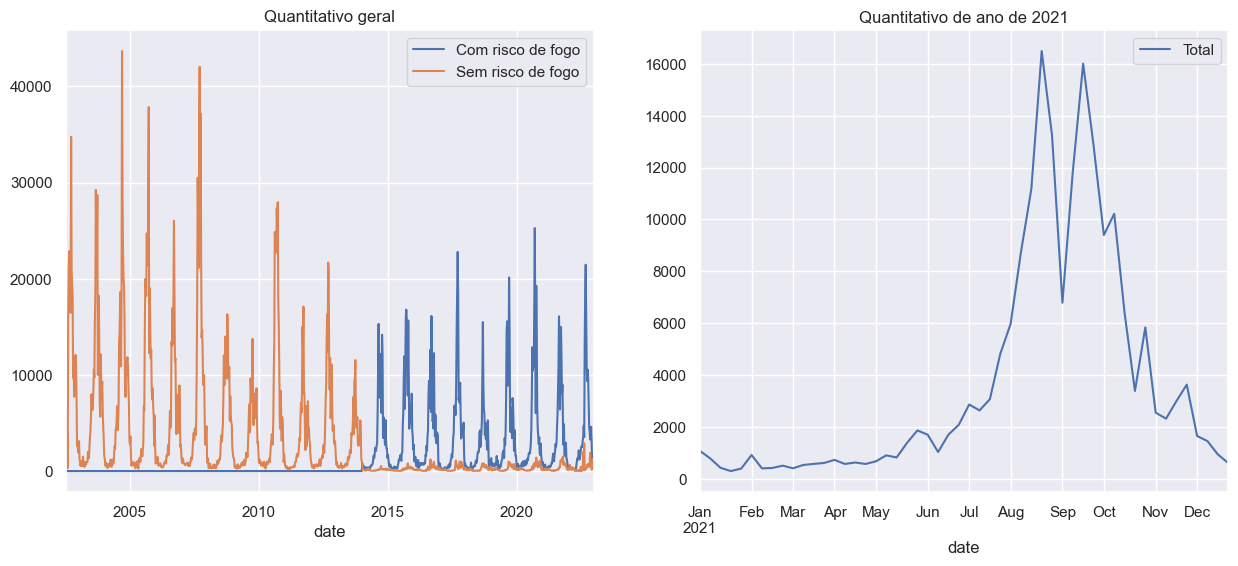

In [21]:
# analise quantitativa dos dados com relacao a flag risco de fogo
reference_df = df[(df.satelite == 'AQUA_M-T')].copy()

date_risco_counts = reference_df.loc[(df.riscofogo)].groupby(['date'])['date'].count()
date_risco_counts.name = 'Com risco de fogo'
date_sem_risco_counts = reference_df.loc[(df.riscofogo == False)].groupby(['date'])['date'].count()
date_sem_risco_counts.name = 'Sem risco de fogo'

daily_df = pd.concat([date_risco_counts, date_sem_risco_counts], axis=1).fillna(0).astype('int')
daily_df.index = pd.to_datetime(daily_df.index)
daily_df['Total'] = daily_df.iloc[:, 0] + daily_df.iloc[:, 1]
weekly_df = daily_df.resample('W').sum()

fig, axs = plt.subplots(1, 2, figsize=(15,6))
weekly_df.drop(['Total'], axis=1).plot(ax=axs[0], title='Quantitativo geral')
weekly_df.loc['2021'].plot(y='Total', ax=axs[1], title='Quantitativo de ano de 2021')

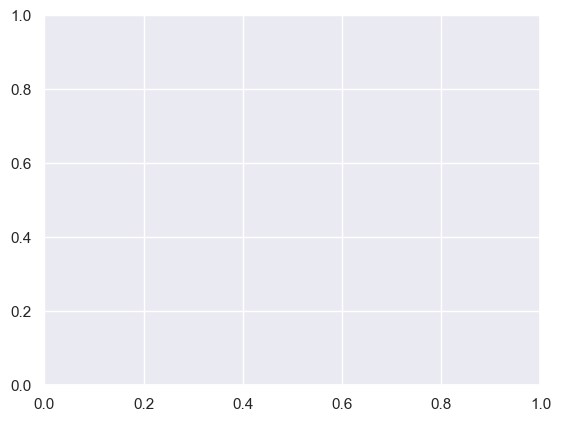

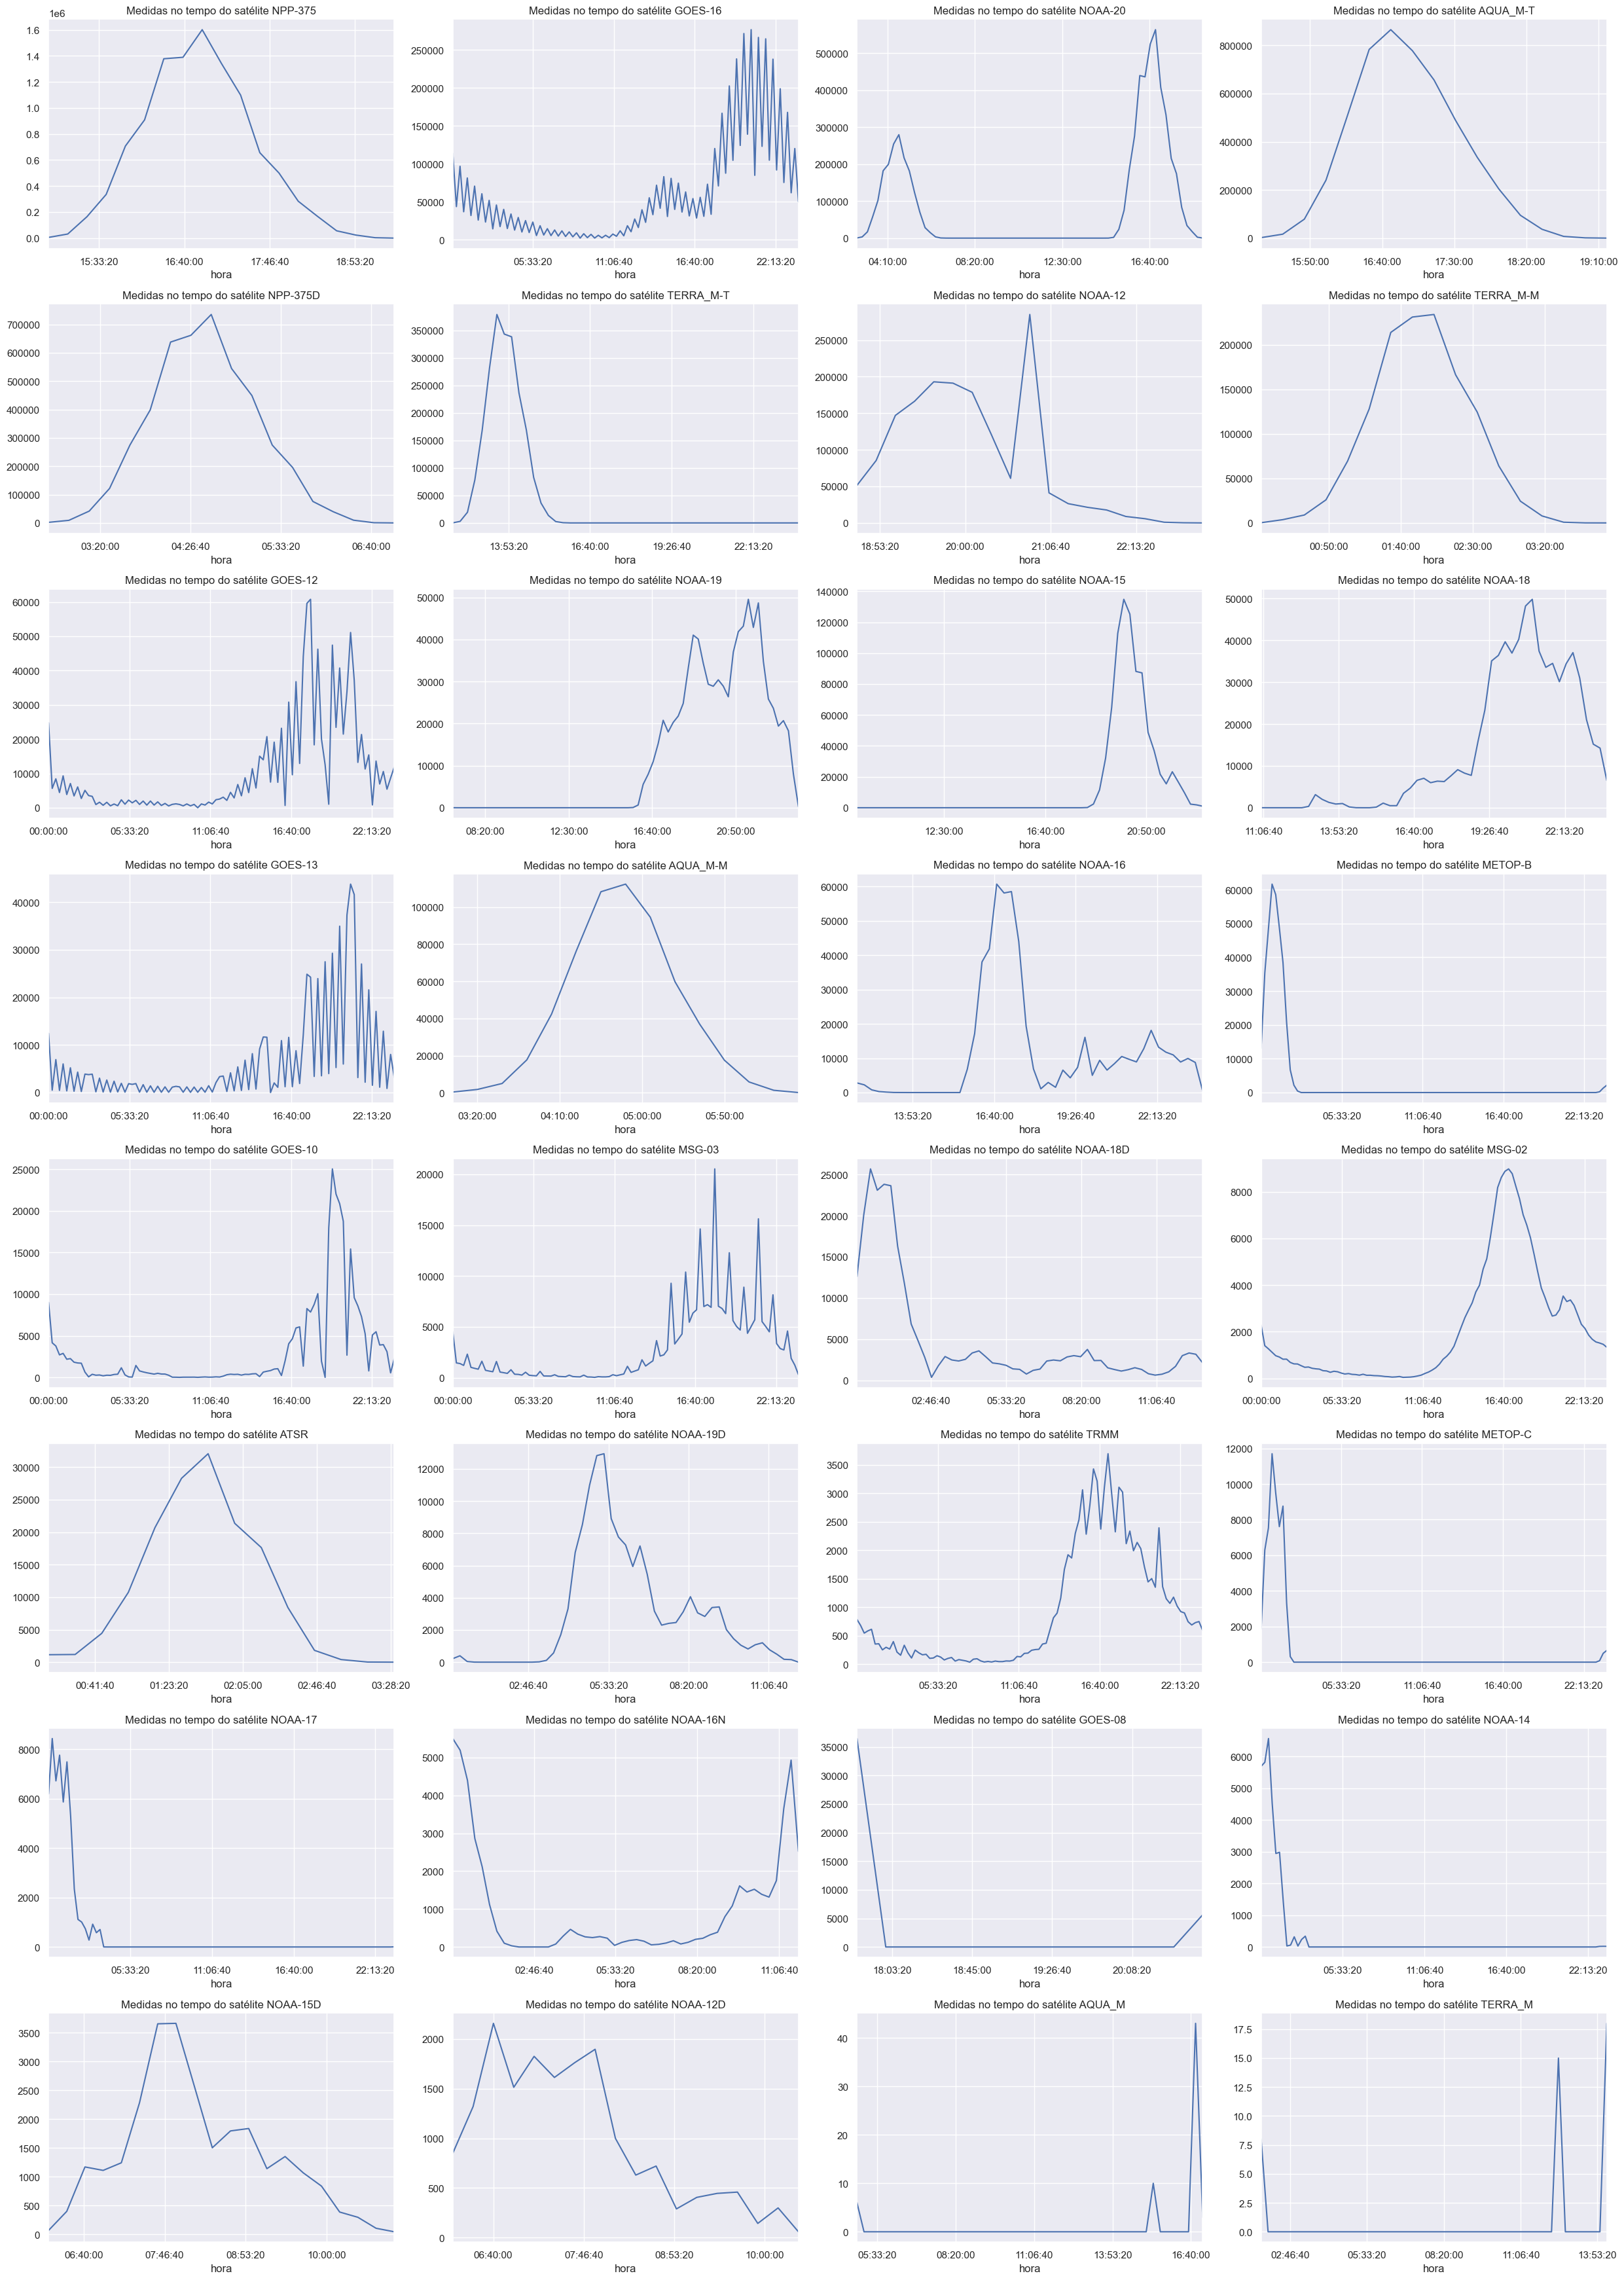

In [22]:
# analise do horários das medicoes dos satelites

def time_measure_dist(satelite='AQUA_M-T', ax=plt.axes()):
  time_counts = df[(df.satelite == satelite)].groupby(['hora'])['hora'].count()
  time_counts.index = pd.TimedeltaIndex(data=time_counts.index.astype('str'))
  time_counts = time_counts.resample('15min').sum()
  time_counts.plot(ax=ax)
  ax.xaxis.set_major_locator(plt.MaxNLocator(5))
  ax.set_title("Medidas no tempo do satélite {0}".format(satelite))

fig, axs = plt.subplots(8, 4, figsize=(25,35))
for i, ax in enumerate(axs.flat):
  time_measure_dist(all_satellites[i], ax)
fig.tight_layout(h_pad=1, w_pad=0.5)


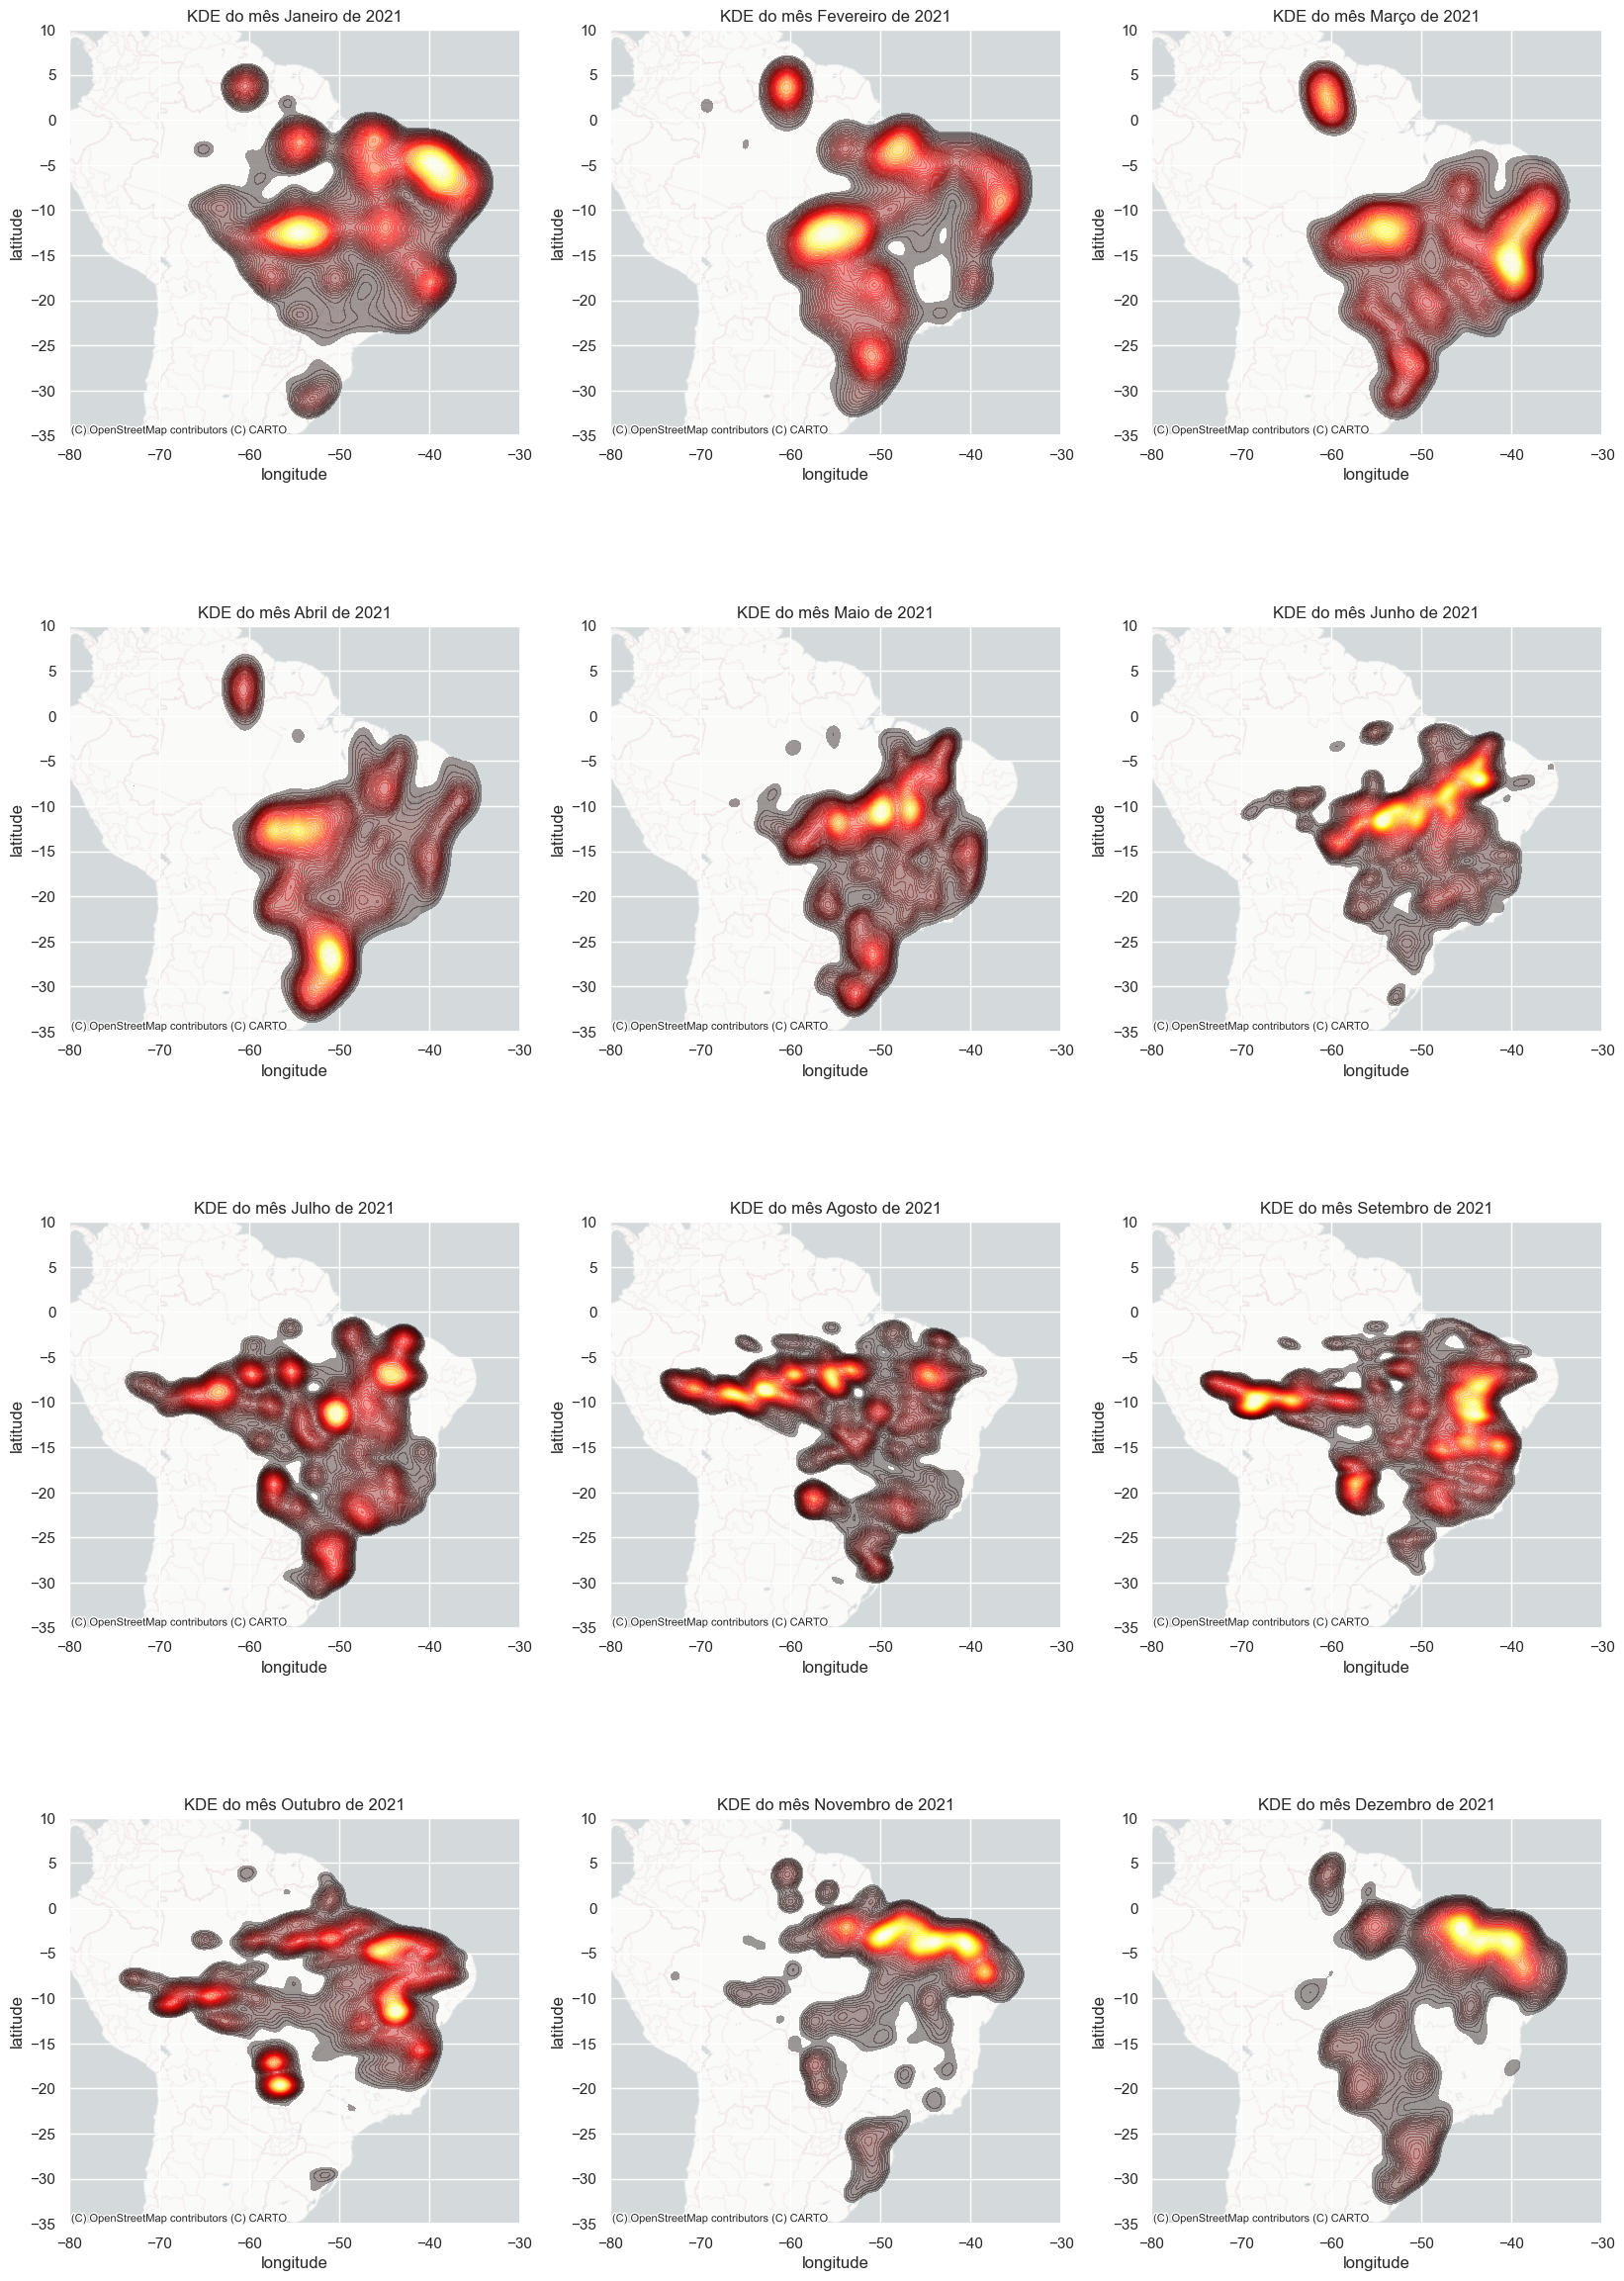

In [24]:
fig, axs = plt.subplots(4, 3, figsize=(20, 30))
year = 2021
for i, ax in enumerate(axs.flat):
  month = i+1
  temp_df = reference_df.query('mes == {} and ano == {}'.format(month, year))
  ax.set_xlim([-80, -30])
  ax.set_ylim([-35, 10])
  sns.kdeplot(
      x=temp_df.longitude,
      y=temp_df.latitude,
      n_levels=50,
      fill=True,
      alpha=0.40,
      cmap="hot",
      bw_adjust=0.6,
      #cbar=True,
      ax=ax
  )
  ax.set_title("KDE do mês {} de {}".format(months_list[i], year))
  contextily.add_basemap(
      ax, 
      crs="EPSG:4326",
      source=contextily.providers.CartoDB.PositronNoLabels,
  )
